# Analysis for the the one without curriculum learning

In [3]:
import tbparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# For the training

In [4]:
from tbparse import SummaryReader
Gen_ARL_train = r"../../TrainerConfig/results/NoCurr42d/Generator/"
Solver_ARL_train = r"../../TrainerConfig/results/NoCurr42d/Solver/"
reader_gen = SummaryReader(Gen_ARL_train)
reader_solver = SummaryReader(Solver_ARL_train)
df_solver = reader_solver.scalars
df_gen = reader_gen.scalars
pd.unique(df_gen["tag"])
# df_gen.head()
# df_gen

array(['Environment/Cumulative Reward', 'Environment/Episode Length',
       'Environment/Lesson Number/aux_input',
       'Environment/Lesson Number/n_obstacles',
       'Losses/Curiosity Forward Loss', 'Losses/Curiosity Inverse Loss',
       'Losses/Policy Loss', 'Losses/Value Loss', 'Policy/Beta',
       'Policy/Curiosity Reward', 'Policy/Curiosity Value Estimate',
       'Policy/Entropy', 'Policy/Epsilon', 'Policy/Extrinsic Reward',
       'Policy/Extrinsic Value Estimate', 'Policy/Learning Rate', 'Score',
       'Y_difference', 'distance', 'height', 'theta'], dtype=object)

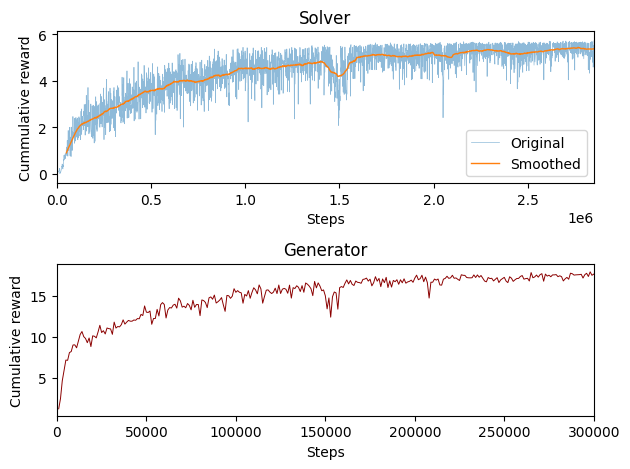

In [8]:
auxs = [0, .3, .5, .75, 1] # Threshold when switching to the next auxiliary input
solver_cum_pd = df_solver.loc[df_solver["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
ax1 = plt.subplot(2,1,1)

maxstep = 2.85e6
#  Generator
kwards = {'x':"step", 'y':"value", "kind":"line"}
solver_cum_pd.plot(**kwards, linewidth=.5, ax=ax1, alpha=.5, label="Original")
#  Smoothed version
solver_cum_pd.rolling(100).mean().plot(**kwards, linewidth=1, ax=ax1, label="Smoothed")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cummulative reward")
ax1.set_xlim(0, maxstep)
ax1.set_title("Solver")
fill_args = {'alpha':0.1}
ymax = 6

# Solver
maxstep = 3.1e5
ymax=20
ymin=-1
# Solver
ax2 = plt.subplot(2,1,2)
gen_cum_pd = df_gen.loc[df_gen["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
gen_cum_pd.plot(**kwards, ax=ax2, color='darkred', linewidth=.7, label="")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Cumulative reward")
ax2.set_xlim(0, 3e5)
# ax2.legend("", frameon=False)
ax2.set_title("Generator")
ax2.legend("", frameon=False)
plt.tight_layout()
plt.savefig("images/Cumm_reward_NoCurr42d.pdf")

# For test